In [3]:
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit,transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
print("Imports Successful")

Imports Successful


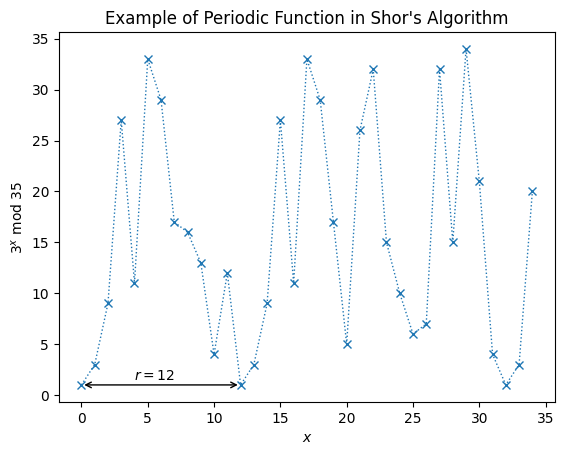

In [4]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

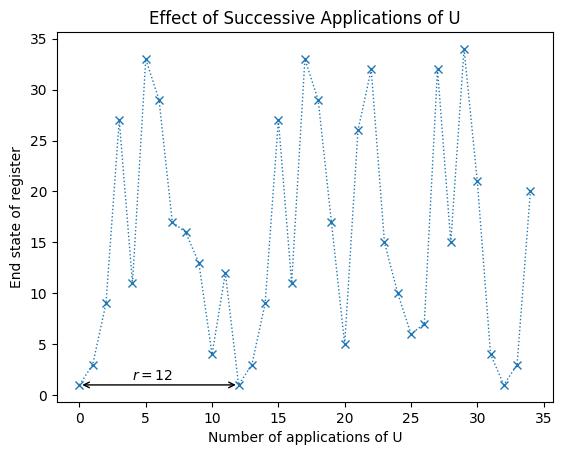

In [5]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

In [6]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [7]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [8]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [9]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

In [13]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

{'00000000': 260, '11000000': 247, '01000000': 253, '10000000': 264}


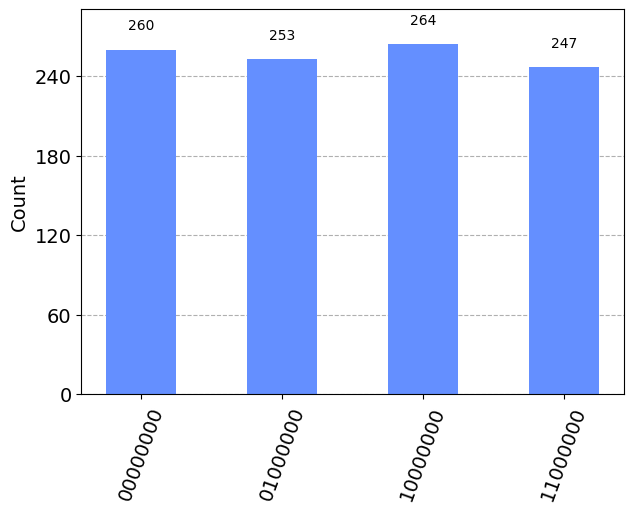

In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token="00659ea3dad545c3410333fb41efe29abc51cd4e88de1fc6a8bc842638843a309a7ada08d239c6d9061a1e19c66189d364b5092780e83b2d2c74e615422380c9")

# Assuming 'qc' is your quantum circuit; replace this with your actual circuit definition
#qc = QuantumCircuit(2, 2)  # Example circuit with 2 qubits and 2 classical bits
#qc.h(0)  # Apply H gate on qubit 0
#qc.cx(0, 1)  # Apply CNOT gate on qubits 0 and 1
qc.measure(range(8), range(8))
#qc.measure_all()  # Measure all qubits
# Initialize the Aer simulator
aer_sim = AerSimulator()

# Generate preset pass manager
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

# Run the pass manager on the quantum circuit
isa_qc = pm.run(qc)

# Transpile the circuit for the Aer simulator
transpiled_qc = transpile(isa_qc, aer_sim)

# Run the simulation
job = aer_sim.run(transpiled_qc, shots=1024)
result = job.result()

# Print the counts
counts = result.get_counts(transpiled_qc)
print(counts)

# Visualize the measurement outcomes
plot_histogram(counts)


In [32]:
from collections import defaultdict

# Example input dictionary
counts = {
    '110111000000 11000000': 67, '110100000000 00000000': 66, '110101000000 01000000': 71, 
    '010010000000 10000000': 64, '010001000000 01000000': 64, '110110000000 10000000': 75, 
    '010000000000 00000000': 51, '000101000000 01000000': 62, '000110000000 10000000': 55, 
    '000100000000 00000000': 71, '011100000000 00000000': 69, '011101000000 01000000': 60, 
    '011110000000 10000000': 61, '000111000000 11000000': 74, '011111000000 11000000': 55, 
    '010011000000 11000000': 59
}

# Aggregate counts based on the least significant 8 bits
aggregated_counts = defaultdict(int)

for key, count in counts.items():
    # Extract the least significant 8 bits
    least_significant_8_bits = key[-8:]
    # Sum up the counts
    aggregated_counts[least_significant_8_bits] += count

# Convert defaultdict back to a regular dictionary for a cleaner output
aggregated_counts = dict(aggregated_counts)

print(aggregated_counts)


{'11000000': 255, '00000000': 257, '01000000': 257, '10000000': 255}


In [15]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [16]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [17]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [18]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.50      1/2            2
2   0.00      0/1            1
3   0.75      3/4            4


In [19]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [20]:
a2jmodN(7, 2049, 53)

47

In [25]:
N = 15

In [26]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [23]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [17]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Initialize the Aer simulator
    aer_sim = AerSimulator()

# Generate preset pass manager
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

# Run the pass manager on the quantum circuit
    isa_qc = pm.run(qc)

# Transpile the circuit for the Aer simulator
    transpiled_qc = transpile(isa_qc, aer_sim)

# Run the simulation
    job = aer_sim.run(transpiled_qc, shots=1)
    result = job.result()

# Print the counts
    counts = result.get_counts(transpiled_qc)
    print(counts)
    # Extract the first key from the dictionary
    reading = next(iter(counts))
    
    # Convert the binary string to an integer
    reading_int = int(reading, 2)
    
    # Calculate the phase
    phase = reading_int / (2 ** N_COUNT)
    
    return phase

# Visualize the measurement outcomes
    #plot_histogram(counts)
    #readings = job.result().get_memory()
    #print("Register Reading: " + readings[0])
    #phase = int(readings[0],2)/(2**N_COUNT)
    #print(f"Corresponding Phase: {phase}")
    #return phase

In [18]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)
#reading=print(qpe_amod15(a)) # Phase = s/r

#Fraction(phase).limit_denominator(15)

{'00000000': 1}


Fraction(0, 1)

In [19]:
def calculate_phase_from_dict(readings, n_count=8):
    """
    Calculate the phase from the first binary register reading in the dictionary.
    
    Parameters:
    reading_dict (dict): A dictionary where keys are binary register readings.
    n_count (int): The number of bits in the reading. Default is 8.

    Returns:
    float: The corresponding phase of the first binary reading.
    """
    # Extract the first key from the dictionary
    reading = next(iter(reading_dict))
    
    # Convert the binary string to an integer
    reading_int = int(reading, 2)
    
    # Calculate the phase
    phase = reading_int / (2 ** n_count)
    
    return phase

# Example usage
reading_dict = {'00000000': 1}
phase = calculate_phase_from_dict(reading_dict)
print(f"Register Reading: {next(iter(reading_dict))}")
print(f"Corresponding Phase: {phase}")


Register Reading: 00000000
Corresponding Phase: 0.0


In [20]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


In [21]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[35, 1]


In [24]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
{'10000000': 1}
Result: r = 2
Guessed Factors: 1 and 1

ATTEMPT 2:
{'00000000': 1}
Result: r = 1

ATTEMPT 3:
{'01000000': 1}
Result: r = 4
Guessed Factors: 1 and 5
*** Non-trivial factor found: 5 ***
